In [32]:
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# my own module
from conf.configure import Configure
from utils import data_util

In [2]:
import numpy as np
import pandas as pd
import datetime
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
import time
#%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LassoCV,LassoLarsCV, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from scipy.stats import skew
from time import time

R2 = make_scorer(r2_score, greater_is_better=True)

In [3]:
print 'load datas...'
train, test = data_util.load_dataset()

y_train_all = train['y']
del train['ID']
del train['y']
id_test = test['ID']
del test['ID']

load datas...


In [4]:
X_train = train
X_test = test
y_train = y_train_all
y_mean = np.mean(y_train)
del train, test, y_train_all

In [46]:
def DeepCV(train, y_train_all, model): 
    train_r2_scores = []
    val_r2_scores = []
    num_boost_roundses = []
    df_columns = train.columns.values
    for i in range(0, 5):
        random_state = 42 + i
        X_train, X_val, y_train, y_val = train_test_split(train, y_train_all, test_size=0.25, random_state=random_state)

        dtrain = xgb.DMatrix(X_train, y_train, feature_names=df_columns)
        dval = xgb.DMatrix(X_val, y_val, feature_names=df_columns)

        y_mean = np.mean(y_train)

        cv_result = xgb.cv(dict(xgb_params, base_score=y_mean),  # base prediction = mean(target)
                           dtrain,
                           num_boost_round=2000,  # increase to have better results (~700)
                           early_stopping_rounds=50,
                           )

        num_boost_rounds = len(cv_result)
        num_boost_roundses.append(num_boost_rounds)
        model = xgb.train(dict(xgb_params, base_score=y_mean), dtrain, num_boost_round=num_boost_rounds)
        train_r2_score = r2_score(dtrain.get_label(), model.predict(dtrain))
        val_r2_score = r2_score(dval.get_label(), model.predict(dval))
        print 'perform {} cross-validate: train r2 score = {}, validate r2 score = {}'.format(i + 1, train_r2_score,
                                                                                              val_r2_score)
        train_r2_scores.append(train_r2_score)
        val_r2_scores.append(val_r2_score)

    print '\naverage train r2 score = {}, average validate r2 score = {}'.format(
        sum(train_r2_scores) / len(train_r2_scores),
        sum(val_r2_scores) / len(val_r2_scores))

    
def PrintImportance(X_train, y_train, model):
    model.fit(X_train, y_train)
    feat_imp = pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False)[:50]
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.figure(figsize=(50,50))

In [5]:
def CV(train, y, model, test_size=.2, CV_metric=r2_score):
    X_train, X_val, y_train, y_val=train_test_split(train, y, test_size=test_size, 
                                                random_state=123)

    model.fit(X_train, y_train)
    
    train_score = CV_metric(y_train, model.predict(X_train))
    val_score = CV_metric(y_val, model.predict(X_val))
    print 'train_score =', train_score, ', val_score =', val_score

[0]	train-rmse:12.6415	test-rmse:12.6389
[50]	train-rmse:11.1931	test-rmse:11.1965
[100]	train-rmse:10.1987	test-rmse:10.2063
[150]	train-rmse:9.54607	test-rmse:9.55825
[200]	train-rmse:9.10687	test-rmse:9.12412
[250]	train-rmse:8.82474	test-rmse:8.84976
[300]	train-rmse:8.63685	test-rmse:8.66969
[350]	train-rmse:8.50951	test-rmse:8.55405
[400]	train-rmse:8.41913	test-rmse:8.48062
[450]	train-rmse:8.35144	test-rmse:8.43056
[500]	train-rmse:8.29716	test-rmse:8.3926
[550]	train-rmse:8.25092	test-rmse:8.36588
[600]	train-rmse:8.20874	test-rmse:8.34704
[650]	train-rmse:8.17015	test-rmse:8.3299
[700]	train-rmse:8.13405	test-rmse:8.31785
[750]	train-rmse:8.10022	test-rmse:8.30829
[800]	train-rmse:8.06867	test-rmse:8.30293
[850]	train-rmse:8.03862	test-rmse:8.29791
[900]	train-rmse:8.01135	test-rmse:8.29603
[950]	train-rmse:7.98647	test-rmse:8.29361
[1000]	train-rmse:7.96042	test-rmse:8.29231


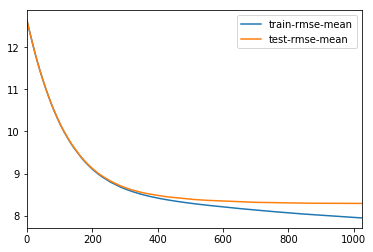

In [50]:
xgb_params = {
    'eta': .005,
    'max_depth': 2,
    'subsample': 0.95,
    'reg_alpha': 0,
    'base_score': y_mean,
    'min_child_weight':6,
    'colsample_bytree': 0.55,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'booster' :'gbtree',
    'tuneLength': 3,
    'seed': 123
}

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=5000, early_stopping_rounds=20,\
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [48]:
DeepCV(X_train, y_train, xgb_params)

perform 1 cross-validate: train r2 score = 0.595453981973, validate r2 score = 0.581011133753
perform 2 cross-validate: train r2 score = 0.596092020712, validate r2 score = 0.570320445277
perform 3 cross-validate: train r2 score = 0.603149507987, validate r2 score = 0.552069231586
perform 4 cross-validate: train r2 score = 0.577652511815, validate r2 score = 0.614379762484
perform 5 cross-validate: train r2 score = 0.630138742536, validate r2 score = 0.489787532386

average train r2 score = 0.600497353005, average validate r2 score = 0.561513621097


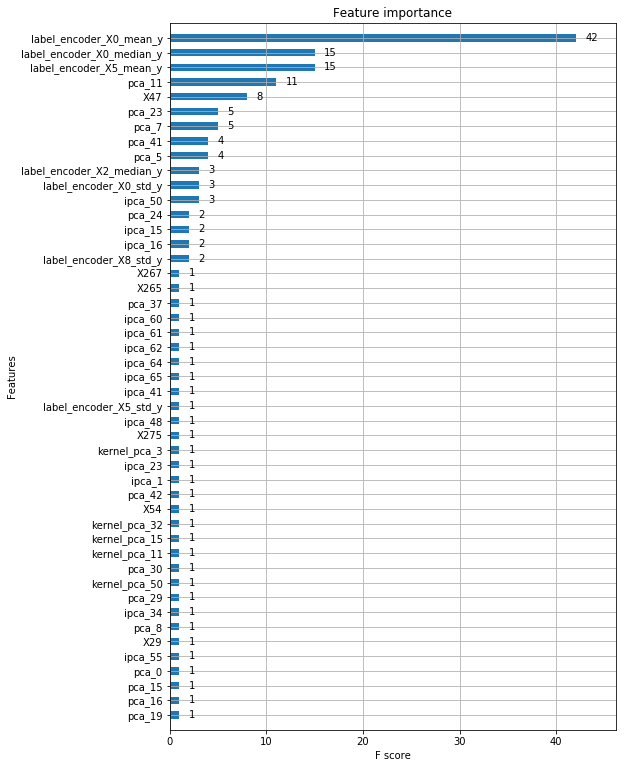

In [33]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [38]:
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.1, n_estimators=50, max_depth=5, gamma=0, \
                          subsample=.8, colsample_bytree=.8,nthread=-1,scale_pos_weight=1)
param_grid = {
       'max_depth': np.arange(3,10,2),
       'min_child_weight': np.arange(1,6,2),
        'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=R2)
model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: 0.57624, std: 0.09511, params: {'seed': 123, 'max_depth': 3, 'min_child_weight': 1}, mean: 0.57573, std: 0.09273, params: {'seed': 123, 'max_depth': 3, 'min_child_weight': 3}, mean: 0.57672, std: 0.09463, params: {'seed': 123, 'max_depth': 3, 'min_child_weight': 5}, mean: 0.56828, std: 0.09501, params: {'seed': 123, 'max_depth': 5, 'min_child_weight': 1}, mean: 0.56828, std: 0.09426, params: {'seed': 123, 'max_depth': 5, 'min_child_weight': 3}, mean: 0.56557, std: 0.09187, params: {'seed': 123, 'max_depth': 5, 'min_child_weight': 5}, mean: 0.55899, std: 0.09431, params: {'seed': 123, 'max_depth': 7, 'min_child_weight': 1}, mean: 0.55675, std: 0.09162, params: {'seed': 123, 'max_depth': 7, 'min_child_weight': 3}, mean: 0.55976, std: 0.09419, params: {'seed': 123, 'max_depth': 7, 'min_child_weight': 5}, mean: 0.54711, std: 0.09371, params: {'seed': 123, 'max_depth': 9, 'min_child_weight': 1}, mean: 0.54673, std: 0.09208, params

In [28]:
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.1, n_estimators=50, max_depth=5, gamma=0, 
                          base_score=y_mean,
                          subsample=.8, colsample_bytree=.8,nthread=-1,scale_pos_weight=1,)
param_grid = {
       'max_depth': [2,3,4],
       'min_child_weight': [4,5,6],
        'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=R2)
model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(model.best_score_)

print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: 0.57057, std: 0.06716, params: {'seed': 123, 'max_depth': 2, 'min_child_weight': 4}, mean: 0.57024, std: 0.06732, params: {'seed': 123, 'max_depth': 2, 'min_child_weight': 5}, mean: 0.57112, std: 0.06875, params: {'seed': 123, 'max_depth': 2, 'min_child_weight': 6}, mean: 0.56475, std: 0.06403, params: {'seed': 123, 'max_depth': 3, 'min_child_weight': 4}, mean: 0.56677, std: 0.06844, params: {'seed': 123, 'max_depth': 3, 'min_child_weight': 5}, mean: 0.56582, std: 0.06614, params: {'seed': 123, 'max_depth': 3, 'min_child_weight': 6}, mean: 0.55523, std: 0.06609, params: {'seed': 123, 'max_depth': 4, 'min_child_weight': 4}, mean: 0.55609, std: 0.06818, params: {'seed': 123, 'max_depth': 4, 'min_child_weight': 5}, mean: 0.55593, std: 0.06719, params: {'seed': 123, 'max_depth': 4, 'min_child_weight': 6}], {'seed': 123, 'max_depth': 2, 'min_child_weight': 6})
Best CV Score:
0.571115884438
0.948729785283


In [34]:
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.1, n_estimators=50, max_depth=2, gamma=0, \
                          subsample=.8, colsample_bytree=.8,nthread=-1,scale_pos_weight=1)
param_grid = {
       'gamma' : [i/10.0 for i in np.arange(0,5)],
       'max_depth': [2],
       'min_child_weight': [6],
        'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=R2)
model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: 0.57165, std: 0.07277, params: {'seed': 123, 'max_depth': 2, 'gamma': 0.0, 'min_child_weight': 6}, mean: 0.57165, std: 0.07277, params: {'seed': 123, 'max_depth': 2, 'gamma': 0.10000000000000001, 'min_child_weight': 6}, mean: 0.57165, std: 0.07277, params: {'seed': 123, 'max_depth': 2, 'gamma': 0.20000000000000001, 'min_child_weight': 6}, mean: 0.57165, std: 0.07277, params: {'seed': 123, 'max_depth': 2, 'gamma': 0.29999999999999999, 'min_child_weight': 6}, mean: 0.57165, std: 0.07277, params: {'seed': 123, 'max_depth': 2, 'gamma': 0.40000000000000002, 'min_child_weight': 6}], {'seed': 123, 'max_depth': 2, 'gamma': 0.0, 'min_child_weight': 6})
Best CV Score:
0.571646023832
0.404843866825


In [36]:
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.1, n_estimators=50, max_depth=2, gamma=0, \
                          min_child_weight=6, seed=123, \
                          subsample=.8, colsample_bytree=.8,nthread=-1,scale_pos_weight=1)
param_grid = {
    'subsample':[i/10.0 for i in np.arange(6,10)],
    'colsample_bytree':[i/10.0 for i in np.arange(6,10)]
       #'gamma' : [0],
       #'max_depth': [6],
       #'min_child_weight': [3],
        #'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=R2)
model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: 0.56952, std: 0.07253, params: {'subsample': 0.59999999999999998, 'colsample_bytree': 0.59999999999999998}, mean: 0.57268, std: 0.07230, params: {'subsample': 0.69999999999999996, 'colsample_bytree': 0.59999999999999998}, mean: 0.57180, std: 0.07236, params: {'subsample': 0.80000000000000004, 'colsample_bytree': 0.59999999999999998}, mean: 0.57463, std: 0.07213, params: {'subsample': 0.90000000000000002, 'colsample_bytree': 0.59999999999999998}, mean: 0.56965, std: 0.07266, params: {'subsample': 0.59999999999999998, 'colsample_bytree': 0.69999999999999996}, mean: 0.57285, std: 0.07446, params: {'subsample': 0.69999999999999996, 'colsample_bytree': 0.69999999999999996}, mean: 0.57297, std: 0.07316, params: {'subsample': 0.80000000000000004, 'colsample_bytree': 0.69999999999999996}, mean: 0.57405, std: 0.07204, params: {'subsample': 0.90000000000000002, 'colsample_bytree': 0.69999999999999996}, mean: 0.56939, std: 0.07280, para

In [37]:
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.1, n_estimators=50, max_depth=2, gamma=0, \
                          min_child_weight=6, seed=123, \
                          subsample=.8, colsample_bytree=.8,nthread=-1,scale_pos_weight=1)
param_grid = {
    'subsample':[i/100.0 for i in np.arange(85,100,5)],
    'colsample_bytree':[i/100.0 for i in np.arange(55,70,5)]
       #'gamma' : [0],
       #'max_depth': [6],
       #'min_child_weight': [3],
        #'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=R2)
model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: 0.57281, std: 0.07226, params: {'subsample': 0.84999999999999998, 'colsample_bytree': 0.55000000000000004}, mean: 0.57328, std: 0.07141, params: {'subsample': 0.90000000000000002, 'colsample_bytree': 0.55000000000000004}, mean: 0.57600, std: 0.07234, params: {'subsample': 0.94999999999999996, 'colsample_bytree': 0.55000000000000004}, mean: 0.57369, std: 0.07212, params: {'subsample': 0.84999999999999998, 'colsample_bytree': 0.59999999999999998}, mean: 0.57463, std: 0.07213, params: {'subsample': 0.90000000000000002, 'colsample_bytree': 0.59999999999999998}, mean: 0.57560, std: 0.07235, params: {'subsample': 0.94999999999999996, 'colsample_bytree': 0.59999999999999998}, mean: 0.57405, std: 0.07258, params: {'subsample': 0.84999999999999998, 'colsample_bytree': 0.65000000000000002}, mean: 0.57424, std: 0.07164, params: {'subsample': 0.90000000000000002, 'colsample_bytree': 0.65000000000000002}, mean: 0.57549, std: 0.07186, para

In [15]:
#del xgbreg
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.1, n_estimators=150, max_depth=6, gamma=0, \
                          min_child_weight=3, seed=123, reg_alpha=0,\
                          subsample=.95, colsample_bytree=.95,nthread=-1,scale_pos_weight=1)
param_grid = {
    'reg_alpha':[1e4,1e5,1e6,1e7]#[1e-5, 1e-2, .1, 1, 100]
    #'subsample':[i/100.0 for i in np.arange(85,100,5)],
    #'colsample_bytree':[i/100.0 for i in np.arange(85,100,5)]
       #'gamma' : [0],
       #'max_depth': [6],
       #'min_child_weight': [3],
        #'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=R2)
model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: -0.45904, std: 0.04750, params: {'reg_alpha': 10000.0}, mean: -0.45798, std: 0.04727, params: {'reg_alpha': 100000.0}, mean: -0.45890, std: 0.04823, params: {'reg_alpha': 1000000.0}, mean: -0.45762, std: 0.04818, params: {'reg_alpha': 10000000.0}], {'reg_alpha': 10000000.0})
Best CV Score:
0.457621258027
13.308499519


In [17]:
#del xgbreg
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.1, n_estimators=150, max_depth=6, gamma=0, \
                          min_child_weight=3, seed=123, reg_alpha=0,\
                          subsample=.95, colsample_bytree=.95,nthread=-1,scale_pos_weight=1)
param_grid = {
    'reg_alpha':[8e6,1e7, 1.5e7]#[1e-5, 1e-2, .1, 1, 100]
    #'subsample':[i/100.0 for i in np.arange(85,100,5)],
    #'colsample_bytree':[i/100.0 for i in np.arange(85,100,5)]
       #'gamma' : [0],
       #'max_depth': [6],
       #'min_child_weight': [3],
        #'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=R2)
model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: -0.45907, std: 0.04900, params: {'reg_alpha': 8000000.0}, mean: -0.45762, std: 0.04818, params: {'reg_alpha': 10000000.0}, mean: -0.45785, std: 0.04751, params: {'reg_alpha': 15000000.0}], {'reg_alpha': 10000000.0})
Best CV Score:
0.457621258027
10.931350414


In [11]:
CV(model=xgbreg, train=X_train, y=y_train)

train_score = 0.899266467874 , val_score = 0.497348555633


In [15]:
xgb_params = {
    'eta': 0.02,
    'max_depth': 6,
    'subsample': 0.95,
    'reg_alpha': 1e7,
    'min_child_weight':3,
    'colsample_bytree': 0.95,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'booster' :'gbtree',
    'tuneLength': 3,
    'seed': 123
}
num_rounds=2000

X_fit, X_val, y_fit, y_val=train_test_split(X_train[:], y_train[:], test_size=0.2, \
                                            random_state=123)
xgfit = xgb.DMatrix(X_fit, label=y_fit)
xgval = xgb.DMatrix(X_val, label=y_val)
watchlist = [ (xgfit,'train'), (xgval, 'test') ]
#clfCV = xgb.train(xgb_params, xgfit, num_rounds)
clfCV = xgb.train(xgb_params, xgfit, num_rounds, watchlist, early_stopping_rounds=20)

y_val_pred = clfCV.predict(xgval)
RMSLE_(y_val,y_val_pred)
# {'subsample': 0.7, 'learning_rate': 0.05, 'seed': 5, 'colsample_bytree': 0.7, 'max_depth': 5} 0.44153281251502002
# {'subsample': 0.7, 'learning_rate': 0.05, 'seed': 5, 'colsample_bytree': 0.7, 'max_depth': 5} #year 
#0.44060260149809333
# {'subsample': 0.7, 'learning_rate': 0.05, 'seed': 5, 'colsample_bytree': 0.7, 'max_depth': 5} #further feat
# 0.44209231186019138
# 'eta': 0.2, 'max_depth': 4,'subsample': 0.7,'colsample_bytree': 0.7,'objective': 'reg:linear','eval_metric': 'rmse',
#'silent': 1,'booster' :'gbtree','tuneLength': 3,'seed': 123, 0.44795306064489548
# 'eta': 0.05, 'max_depth': 7,'subsample': 0.7,'colsample_bytree': 0.7,'objective': 'reg:linear','eval_metric': 'rmse',
#'silent': 1,'booster' :'gbtree','tuneLength': 3,'seed': 5, 0.43906751173727021
# 'eta': 0.05, 'max_depth': 7,'subsample': 0.7,'colsample_bytree': 0.7,'objective': 'reg:linear','eval_metric': 'rmse',
#'silent': 1,'booster' :'gbtree','tuneLength': 3,'seed': 123, 0.43867312921244639

#'eta': 0.1,'max_depth': 6,'subsample': 0.95,'min_child_weight':3,'colsample_bytree': 0.95,
#'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree',
#'tuneLength': 3,'seed': 123, 0.44006308323535842

#'eta': 0.05,'max_depth': 6,'subsample': 0.95,'min_child_weight':3,'colsample_bytree': 0.95,
#'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree',
#'tuneLength': 3,'seed': 123, 0.43956845066724409

#'eta': 0.01,'max_depth': 6,'subsample': 0.95,'min_child_weight':3,'colsample_bytree': 0.95,
#'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree',
#'tuneLength': 3,'seed': 123, 0.44026780405377181

#'eta': 0.1,'max_depth': 6,'subsample': 0.95,'min_child_weight':3,'colsample_bytree': 0.95,
#'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree', 'reg_alpha': 1e7,
#'tuneLength': 3,'seed': 123, 0.44012755182473617

#'eta': 0.05,'max_depth': 6,'subsample': 0.95,'min_child_weight':3,'colsample_bytree': 0.95,
#'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree', 'reg_alpha': 1e7,
#'tuneLength': 3,'seed': 123, 0.43836880534269967

#'eta': 0.02,'max_depth': 6,'subsample': 0.95,'min_child_weight':3,'colsample_bytree': 0.95,
#'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree', 'reg_alpha': 1e7,
#'tuneLength': 3,'seed': 123, 0.43755608914917643

Will train until test error hasn't decreased in 20 rounds.
[0]	train-rmse:8390917.000000	test-rmse:8486741.000000
[1]	train-rmse:8246371.000000	test-rmse:8346285.500000
[2]	train-rmse:8100040.500000	test-rmse:8204022.000000
[3]	train-rmse:7956993.500000	test-rmse:8064916.000000
[4]	train-rmse:7816996.500000	test-rmse:7928369.000000
[5]	train-rmse:7681355.500000	test-rmse:7795867.000000
[6]	train-rmse:7547419.500000	test-rmse:7663968.000000
[7]	train-rmse:7416143.000000	test-rmse:7538018.000000
[8]	train-rmse:7288152.500000	test-rmse:7414961.500000
[9]	train-rmse:7162958.000000	test-rmse:7293523.000000
[10]	train-rmse:7040066.500000	test-rmse:7172713.000000
[11]	train-rmse:6919939.500000	test-rmse:7055155.000000
[12]	train-rmse:6802649.500000	test-rmse:6941235.000000
[13]	train-rmse:6688374.500000	test-rmse:6831285.000000
[14]	train-rmse:6575982.500000	test-rmse:6723083.500000
[15]	train-rmse:6466426.500000	test-rmse:6619211.000000
[16]	train-rmse:6358685.500000	test-rmse:6516100.000000

0.43755608914917643

In [72]:
xgb_params = {
    'eta': .1,#0.02,
    'max_depth': 6,
    'subsample': 0.95,
    'reg_alpha': 0,#1e7,
    'min_child_weight':3,
    'colsample_bytree': 0.95,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'booster' :'gbtree',
    'tuneLength': 3,
    'seed': 5
}

dtrain = xgb.DMatrix(X_train[predictors], np.log(y_train))
dtest = xgb.DMatrix(X_test[predictors])

num_boost_rounds = 250#len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

#fig, ax = plt.subplots(1, 1, figsize=(8, 13))
#xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

y_predict = model.predict(dtest)
y_predict = np.exp(y_predict)
#y_predict = np.round(y_predict)#np.round(y_predict * 0.99)
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})



In [76]:
xgb_params = {
    'eta': .02,#0.02,
    'max_depth': 6,
    'subsample': 0.95,
    'reg_alpha': 1e7,
    'min_child_weight':3,
    'colsample_bytree': 0.95,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'booster' :'gbtree',
    'tuneLength': 3,
    'seed': 5
}

dtrain = xgb.DMatrix(X_train[predictors], y_train)
dtest = xgb.DMatrix(X_test[predictors])

num_boost_rounds = 250#len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

#fig, ax = plt.subplots(1, 1, figsize=(8, 13))
#xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

y_predict = model.predict(dtest)
#y_predict = np.round(y_predict)#np.round(y_predict * 0.99)
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})



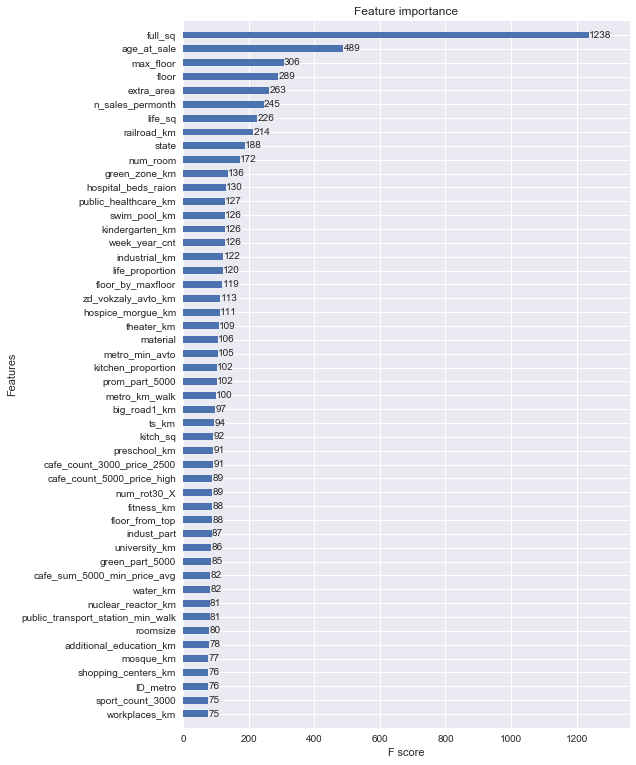

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [79]:
 output.to_csv('../result/Jun14_5_AddFeat_paraTuning_etaPt02_subsPt95_maxD6_childH3_num250.csv', index=False)